In [18]:
import matplotlib.pyplot as plt

def plot(h,epochs):
    LOSS = 0; ACCURACY = 1
    training = np.zeros((2,epochs)); testing = np.zeros((2,epochs))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']    # validation loss
    training[ACCURACY] = h.history['mae']
    testing[ACCURACY] = h.history['val_mae']  # validation accuracy

    epochs = range(1,epochs+1)
    fig, axs = plt.subplots(1,2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY),('loss', 'mae')):   
        axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
        axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
        axs[i].set_title('Training and test ' + label)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend()
        axs[i].grid(True)
    plt.show()

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('ratings_senior.csv', header=0, delimiter = ',',names=['user_id', 'item_id', 'rating', 'demographic'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in data.iterrows():
    if movie_id_to_new_id.get(row['item_id']) is None:
        movie_id_to_new_id[row['item_id']] = id
        data.at[index, 'item_id'] = id
        id += 1
    else:
        data.at[index, 'item_id'] = movie_id_to_new_id.get(row['item_id'])

NUM_USERS = len(data.user_id.unique())
NUM_ITEMS = len(data.item_id.unique())

train, test = train_test_split(data, test_size=0.25,random_state=50)
train = np.array(train)
test = np.array(test)

USER = 0; ITEM = 1; RATING = 2; DEMOGRAPHIC = 3

print ('Number of movies', NUM_ITEMS)
print ('Number of users', NUM_USERS)

Number of movies 3706
Number of users 6040


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 5)         18535       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 5)         30205       ['user-input[0][0]']             
                                                                                            

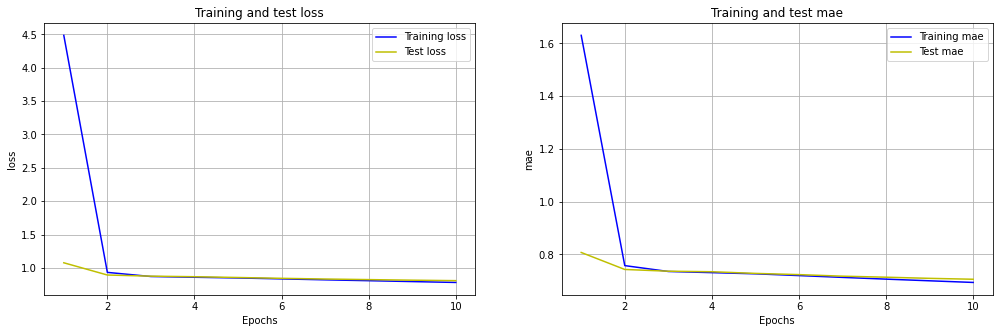

In [20]:
# DEEPMF ML1M 
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot
from keras.optimizers import Adam

latent_dim = 5  # to speed KMeans runs

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(NUM_ITEMS + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(NUM_USERS + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

dot = Dot(axes=1,name='movie-user-concat')([movie_vec, user_vec])

model_deepMF = Model([user_input, movie_input], dot)
model_deepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')

model_deepMF.summary()

EPOCHS = 10
history_deepMF = model_deepMF.fit([train[:,USER],train[:,ITEM]],train[:,RATING], 
                    validation_data=([test[:,USER],test[:,ITEM]], test[:,RATING]), 
                    epochs=EPOCHS, verbose=1)
plot(history_deepMF,EPOCHS)

In [21]:
model_deepMF.save('ModelDeepMF.h5')

In [22]:
from keras.models import Model

# we create two models, from model_deepMF, to get user's and item's embeddings
model_user_embeddings = Model(inputs=user_input, outputs=user_embedding)
model_movie_embeddings = Model(inputs=movie_input, outputs=movie_embedding)

# obtaining all the existing users an items embeddings
user_embeddings = model_user_embeddings.predict(np.array(range(NUM_USERS+1)))
movie_embeddings = model_movie_embeddings.predict(np.array(range(NUM_ITEMS+1)))
    

116/116 [==============================] - 0s 1ms/step


In [23]:
import random

# creating a dataset of training casted ratings: <user embedding, item embedding, rating>
def get_dataset(data):
    embedding_dataset = np.zeros((len(data),latent_dim * 2)) 
    ratings = np.zeros((len(data)))
    demographics = np.zeros((len(data)))
    for i in range(len(data)):
        user_embedding = user_embeddings[int(data[i,USER])][0]
        movie_embedding = movie_embeddings[int(data[i,ITEM])][0]
        ratings[i] = (data[i,RATING]-3)/5.   # normalized -2/5 to 2/5
        demographics[i] = (data[i,DEMOGRAPHIC])
        embedding_dataset[i] = np.concatenate((user_embedding, movie_embedding))
    # add ratings & demographic
    embedding_dataset = np.insert(embedding_dataset, latent_dim * 2, ratings, axis=1)
    embedding_dataset = np.insert(embedding_dataset, latent_dim * 2 + 1, demographics, axis=1)
    return embedding_dataset

# train and test embeddings and ratings datasets (positive values)
embedding_dataset = get_dataset(np.array(data))

In [39]:
print(embedding_dataset[100:107])

[[ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  1.13389516
   0.91184431 -1.04843819 -1.21724105 -0.61503506  0.          1.        ]
 [ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  1.05479705
   1.05902481 -1.04089701 -1.10863638 -0.55878985  0.          1.        ]
 [ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  1.20468009
   1.40904975 -1.56531811 -0.53996813 -0.28316897  0.4         1.        ]
 [ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  0.86340398
   1.00470877 -1.07762361 -0.95413816 -0.78590029  0.2         1.        ]
 [ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  0.90995932
   0.7762782  -0.8638379  -0.8660441  -1.23006094  0.2         1.        ]
 [ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  1.36450791
   1.61837137 -1.065045   -1.29333162  0.32234526  0.2         1.        ]
 [ 0.9532851   0.52994061 -0.92782587 -0.79708773 -0.88386393  0.90126789
   1.37717116 -1.20718813 -1.218

In [62]:
# GANMF ML1M 
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, \
                         Dot, LeakyReLU, BatchNormalization, Lambda, multiply
from keras.optimizers import Adam
from tensorflow.keras import backend as K

class GAN():
    def __init__(self):
        self.latent_dim = latent_dim
        self.noise_dim = 100
        self.num_classes = 2

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates user
        z = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,))
        fake_sample = self.generator([z, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated users as input and determines validity
        validity = self.discriminator([fake_sample, label])

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([z, label], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()
        
        # mapping network (input: z)  
        ML1M = 7
        Netflix = 8
        model.add(Dense(8, input_dim=self.noise_dim))
             
        # truncation trick
        #model.add(Lambda(lambda x: K.mean(x) + 0.85*(x-K.mean(x))))
         
        # generator (input: w)
        #model.add(Dense(10, input_dim=self.noise_dim))
        
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(10))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Dense(self.latent_dim*2+1, activation='linear'))
        model.summary()

        noise = Input(shape=(self.noise_dim))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.noise_dim)(label))
        
        model_input = multiply([noise, label_embedding])       
        fake_sample = model(model_input)

        return Model([noise, label], fake_sample)

    
    def build_discriminator(self):

        model = Sequential()
        model.add(Dense(6, input_dim=self.latent_dim*2 + 1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        sample = Input(shape=(self.latent_dim*2 + 1))
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, latent_dim*2 + 1)(label))
        flat_sample = Flatten()(sample)
        
        model_input = multiply([flat_sample, label_embedding])
        validity = model(model_input)

        return Model([sample, label], validity)

    
    def train(self, dataset, demographic, epochs, batch_size=128, sample_interval=50, num_training_samples=100000):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of real samples
            idx = np.random.randint(0, num_training_samples, batch_size)
            real_samples, labels = dataset[idx], demographic[idx]
           
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

            # Generate a batch of fake users
            fake_samples = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([real_samples, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([fake_samples, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                

if __name__ == '__main__':
    np.random.seed(1001)
    gan = GAN()
    gan.train(embedding_dataset[:,:-1], embedding_dataset[:,-1], epochs=20000, batch_size=128, sample_interval=200, 
              num_training_samples = len(embedding_dataset))
    gan.generator.save('GANMF-3.h5')
    
    

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 6)                 72        
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 6)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 7         
                                                                 
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 8)                 808       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None

4/4 [==============================] - 0s 4ms/step
200 [D loss: 0.675347, acc.: 54.30%] [G loss: 0.643615]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
400 [D loss: 0.708160, acc.: 58.98%] [G loss: 0.628669]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
600 [D loss: 0.701801, acc.: 42.19%] [G loss: 0.667188]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
800 [D loss: 0.701388, acc.: 29.69%] [G loss: 0.689436]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
1000 [D loss: 0.698936, acc.: 45.70%] [G loss: 0.703434]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
1200 [D loss: 0.697808, acc.: 47.66%] [G loss: 0.706029]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
1400 [D loss: 0.681148, acc.: 50.00%] [G loss: 0.741174]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
1600 [D loss: 0.682099, acc.: 50.00%] [G loss: 0.751266]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
1800 [D loss: 0.688589, acc.: 47.27%] [G loss: 0.713249]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
2000 [D loss: 0.696645, acc.: 36.72%] [G loss: 0.696854]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
2200 [D loss: 0.695042, acc.: 40.23%] [G loss: 0.704200]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
2400 [D loss: 0.684882, acc.: 50.78%] [G loss: 0.724281]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step
2600 [D loss: 0.689401, acc.: 46.09%] [G loss: 0.709056]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
2800 [D loss: 0.693218, acc.: 37.89%] [G loss: 0.706181]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
3000 [D loss: 0.690783, acc.: 50.00%] [G loss: 0.715594]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
3200 [D loss: 0.689913, acc.: 50.00%] [G loss: 0.715308]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step
3400 [D loss: 0.695200, acc.: 51.17%] [G loss: 0.697538]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
3600 [D loss: 0.694963, acc.: 33.59%] [G loss: 0.706738]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
3800 [D loss: 0.691388, acc.: 50.00%] [G loss: 0.723434]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
4000 [D loss: 0.688892, acc.: 47.66%] [G loss: 0.724885]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
4200 [D loss: 0.686127, acc.: 50.00%] [G loss: 0.722387]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
4400 [D loss: 0.688912, acc.: 57.03%] [G loss: 0.719555]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
4600 [D loss: 0.696878, acc.: 37.50%] [G loss: 0.701600]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
4800 [D loss: 0.700446, acc.: 35.55%] [G loss: 0.711607]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
5000 [D loss: 0.691174, acc.: 41.80%] [G loss: 0.729867]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
5200 [D loss: 0.693764, acc.: 43.75%] [G loss: 0.707144]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
5400 [D loss: 0.686908, acc.: 41.02%] [G loss: 0.706703]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
5600 [D loss: 0.693369, acc.: 41.02%] [G loss: 0.694485]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
5800 [D loss: 0.693427, acc.: 41.41%] [G loss: 0.692426]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
6000 [D loss: 0.695418, acc.: 42.58%] [G loss: 0.689791]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
6200 [D loss: 0.694836, acc.: 32.81%] [G loss: 0.695950]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
6400 [D loss: 0.693391, acc.: 41.41%] [G loss: 0.697985]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
6600 [D loss: 0.692071, acc.: 55.86%] [G loss: 0.698354]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 3ms/step
6800 [D loss: 0.692829, acc.: 53.52%] [G loss: 0.698703]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
7000 [D loss: 0.693774, acc.: 49.61%] [G loss: 0.696836]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step
7200 [D loss: 0.693834, acc.: 42.19%] [G loss: 0.693139]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
7400 [D loss: 0.693422, acc.: 44.53%] [G loss: 0.688672]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
7600 [D loss: 0.693904, acc.: 49.61%] [G loss: 0.685770]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 4ms/step
7800 [D loss: 0.694182, acc.: 49.61%] [G loss: 0.685449]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
8000 [D loss: 0.693717, acc.: 48.44%] [G loss: 0.690636]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
8200 [D loss: 0.693696, acc.: 39.06%] [G loss: 0.693175]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
8400 [D loss: 0.693360, acc.: 46.88%] [G loss: 0.692748]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
8600 [D loss: 0.693229, acc.: 51.56%] [G loss: 0.692340]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
8800 [D loss: 0.692839, acc.: 57.42%] [G loss: 0.690828]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
9000 [D loss: 0.692766, acc.: 52.73%] [G loss: 0.689689]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
9200 [D loss: 0.693438, acc.: 50.00%] [G loss: 0.690411]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 4ms/step
9400 [D loss: 0.693631, acc.: 50.78%] [G loss: 0.691177]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
9600 [D loss: 0.693869, acc.: 50.00%] [G loss: 0.691683]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
9800 [D loss: 0.692992, acc.: 57.03%] [G loss: 0.693690]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
10000 [D loss: 0.692668, acc.: 55.08%] [G loss: 0.692909]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
10200 [D loss: 0.692752, acc.: 50.00%] [G loss: 0.690527]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
10400 [D loss: 0.693014, acc.: 47.66%] [G loss: 0.690875]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
10600 [D loss: 0.693698, acc.: 46.48%] [G loss: 0.691184]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
10800 [D loss: 0.694092, acc.: 46.09%] [G loss: 0.689929]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step
11000 [D loss: 0.693928, acc.: 42.19%] [G loss: 0.692072]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
11200 [D loss: 0.693007, acc.: 46.48%] [G loss: 0.695088]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
11400 [D loss: 0.693159, acc.: 51.95%] [G loss: 0.695028]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
11600 [D loss: 0.693086, acc.: 49.22%] [G loss: 0.693178]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
11800 [D loss: 0.693626, acc.: 35.94%] [G loss: 0.692498]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
12000 [D loss: 0.692915, acc.: 53.91%] [G loss: 0.692883]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
12200 [D loss: 0.693228, acc.: 53.12%] [G loss: 0.690987]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step
12400 [D loss: 0.693793, acc.: 29.30%] [G loss: 0.692415]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
12600 [D loss: 0.693478, acc.: 48.44%] [G loss: 0.691302]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
12800 [D loss: 0.693309, acc.: 48.83%] [G loss: 0.691924]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
13000 [D loss: 0.693000, acc.: 52.34%] [G loss: 0.693284]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
13200 [D loss: 0.692321, acc.: 69.14%] [G loss: 0.694451]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
13400 [D loss: 0.693747, acc.: 28.52%] [G loss: 0.692314]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step
13600 [D loss: 0.693866, acc.: 27.34%] [G loss: 0.692957]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
13800 [D loss: 0.693327, acc.: 23.44%] [G loss: 0.692920]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
14000 [D loss: 0.693094, acc.: 51.95%] [G loss: 0.691991]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
14200 [D loss: 0.692532, acc.: 51.56%] [G loss: 0.691879]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
14400 [D loss: 0.693169, acc.: 46.88%] [G loss: 0.692719]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
14600 [D loss: 0.693946, acc.: 35.55%] [G loss: 0.692527]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
14800 [D loss: 0.693373, acc.: 34.77%] [G loss: 0.692183]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
15000 [D loss: 0.692997, acc.: 47.66%] [G loss: 0.693770]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
15200 [D loss: 0.692807, acc.: 51.17%] [G loss: 0.693277]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
15400 [D loss: 0.693577, acc.: 41.41%] [G loss: 0.692318]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
15600 [D loss: 0.693406, acc.: 46.88%] [G loss: 0.693616]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
15800 [D loss: 0.693054, acc.: 51.95%] [G loss: 0.694668]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step
16000 [D loss: 0.693174, acc.: 46.88%] [G loss: 0.692225]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
16200 [D loss: 0.693257, acc.: 50.00%] [G loss: 0.690686]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
16400 [D loss: 0.693316, acc.: 40.23%] [G loss: 0.693109]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
16600 [D loss: 0.693072, acc.: 58.98%] [G loss: 0.692769]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
16800 [D loss: 0.693369, acc.: 50.00%] [G loss: 0.692797]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
17000 [D loss: 0.692843, acc.: 64.45%] [G loss: 0.694546]
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
17200 [D loss: 0.693436, acc.: 42.58%] [G loss: 0.692106]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
17400 [D loss: 0.693296, acc.: 50.39%] [G loss: 0.692567]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
17600 [D loss: 0.693368, acc.: 49.22%] [G loss: 0.693908]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
17800 [D loss: 0.692756, acc.: 65.23%] [G loss: 0.692894]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
18000 [D loss: 0.693620, acc.: 52.34%] [G loss: 0.690367]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
18200 [D loss: 0.693589, acc.: 37.11%] [G loss: 0.694160]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
18400 [D loss: 0.692794, acc.: 42.19%] [G loss: 0.694700]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
18600 [D loss: 0.693051, acc.: 56.64%] [G loss: 0.693532]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 4ms/step
18800 [D loss: 0.693661, acc.: 46.48%] [G loss: 0.690290]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
19000 [D loss: 0.693272, acc.: 40.62%] [G loss: 0.694377]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
19200 [D loss: 0.693083, acc.: 50.39%] [G loss: 0.694543]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
19400 [D loss: 0.693374, acc.: 47.27%] [G loss: 0.693034]
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 1ms/step
19600 [D loss: 0.693070, acc.: 57.42%] [G loss: 0.692257]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step
19800 [D loss: 0.693634, acc.: 51.56%] [G loss: 0.690234]
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


In [85]:
from keras.models import load_model
import statistics
from tensorflow.keras import backend as K
import random as r

############
# creates augmented samples in the format:
# embedding user, embedding item and rating vectors
DEMOGRAPHIC_1 = 0
DEMOGRAPHIC_2 = 1

def get_augmented(model, num_fake_samples_demographic1, num_fake_samples_demographic2):
    # Demographic 1 fake samples generation (e.g. MALE)
    noise = np.random.normal(0, 1.8, (num_fake_samples_demographic1, gan.noise_dim))   
    #labels_zero = np.array([[r.randint(0,1)] for i in range(num_fake_samples_demographic1)])
    labels_zero= np.zeros((num_fake_samples_demographic1, 1))    
    fake_samples_demographic1 = model.predict([noise,labels_zero])
    
    # Demographic 2 fake samples generation (e.g. FEMALE)
    noise = np.random.normal(0, 1, (num_fake_samples_demographic2, gan.noise_dim))
    #labels_one = np.array([[r.randint(0,1)] for i in range(num_fake_samples_demographic2)])
    labels_one= np.ones((num_fake_samples_demographic2, 1))
    fake_samples_demographic2 = model.predict([noise,labels_one]) 
    
    return fake_samples_demographic1, fake_samples_demographic2 


def normalize_ratings(augmented_data, embedd_dataset):
    y = augmented_data[:,-1]
    mu_aug = statistics.mean(y)
    de_aug = statistics.stdev(y, mu_aug)

    mu = statistics.mean(embedd_dataset[:,-1])
    de = statistics.stdev(embedd_dataset[:,-1], mu)
    print(mu, de)

    # Ratings normalization   
    augmented_data[:,-1] *= mu / mu_aug
    mu = statistics.mean(augmented_data[:,-1])
    de = statistics.stdev(augmented_data[:,-1], mu)
    print(mu, de)
    return

FAKE_SAMPLES_DEM1 = 70000
FAKE_SAMPLES_DEM2 = 70000
augmented_1, augmented_2 = get_augmented(load_model('GANMF-3.h5'), FAKE_SAMPLES_DEM1, FAKE_SAMPLES_DEM2)
normalize_ratings(augmented_1, embedding_dataset)
normalize_ratings(augmented_2, embedding_dataset)


2188/2188 [==============================] - 2s 1ms/step
0.194862273784779 0.396094843312238
0.19486228 0.7679866348164939
0.194862273784779 0.396094843312238
0.19486228 0.5746339462224462


In [80]:
# Datos para crear una matriz de resultados de calidad
from sklearn.cluster import KMeans

TESTING_USERS_DEM1 = 500
TESTING_USERS_DEM2 = 500
TESTING_ITEMS = 500
  
clustering_users = KMeans(n_clusters=TESTING_USERS_DEM1, n_init=1, max_iter= 100, verbose=1)
cluster_users = clustering_users.fit_predict(augmented_1[:FAKE_SAMPLES_DEM1,:latent_dim])  
np.save('cluster_users_dem1_' + str(TESTING_USERS_DEM1), cluster_users)  
print("end cluster users dem1: " + str(TESTING_USERS_DEM1))
      
clustering_users = KMeans(n_clusters=TESTING_USERS_DEM2, n_init=1, max_iter= 100, verbose=1)
cluster_users = clustering_users.fit_predict(augmented_2[:FAKE_SAMPLES_DEM2,:latent_dim])  
np.save('cluster_users_dem2_' +  str(TESTING_USERS_DEM2), cluster_users)  
print("end cluster users dem2: " + str(TESTING_USERS_DEM2))

augmented = np.concatenate((augmented_1, augmented_2))  
clustering_items = KMeans(n_clusters=TESTING_ITEMS, n_init=1, max_iter= 100, verbose=1)
cluster_items = clustering_items.fit_predict(augmented[:(FAKE_SAMPLES_DEM1+FAKE_SAMPLES_DEM2),latent_dim:-2])  
np.save('cluster_items_' + str(TESTING_ITEMS), cluster_items)   
print("end cluster items: " + str(TESTING_ITEMS))

Initialization complete
Iteration 0, inertia 18816.6015625
Iteration 1, inertia 16781.171875
Iteration 2, inertia 16315.07421875
Iteration 3, inertia 16111.7109375
Iteration 4, inertia 15988.2392578125
Iteration 5, inertia 15901.51953125
Iteration 6, inertia 15836.1708984375
Iteration 7, inertia 15790.4990234375
Iteration 8, inertia 15757.1142578125
Iteration 9, inertia 15730.603515625
Iteration 10, inertia 15706.9755859375
Iteration 11, inertia 15684.6181640625
Iteration 12, inertia 15666.767578125
Iteration 13, inertia 15653.1044921875
Iteration 14, inertia 15641.033203125
Iteration 15, inertia 15627.5087890625
Iteration 16, inertia 15616.185546875
Iteration 17, inertia 15606.3701171875
Iteration 18, inertia 15596.06640625
Iteration 19, inertia 15587.0205078125
Iteration 20, inertia 15578.6005859375
Iteration 21, inertia 15570.49609375
Iteration 22, inertia 15562.41015625
Iteration 23, inertia 15556.408203125
Iteration 24, inertia 15550.76171875
Iteration 25, inertia 15546.1943359375

Iteration 58, inertia 13692.5244140625
Iteration 59, inertia 13691.892578125
Iteration 60, inertia 13691.3701171875
Iteration 61, inertia 13691.05078125
Iteration 62, inertia 13690.8017578125
Iteration 63, inertia 13690.58984375
Iteration 64, inertia 13690.2744140625
Iteration 65, inertia 13689.9775390625
Iteration 66, inertia 13689.68359375
Iteration 67, inertia 13689.3408203125
Iteration 68, inertia 13688.98828125
Iteration 69, inertia 13688.6875
Iteration 70, inertia 13688.46484375
Iteration 71, inertia 13688.3515625
Iteration 72, inertia 13688.185546875
Iteration 73, inertia 13688.0234375
Iteration 74, inertia 13687.845703125
Iteration 75, inertia 13687.5302734375
Iteration 76, inertia 13687.3369140625
Iteration 77, inertia 13687.1728515625
Iteration 78, inertia 13686.966796875
Iteration 79, inertia 13686.78125
Iteration 80, inertia 13686.44921875
Iteration 81, inertia 13686.150390625
Iteration 82, inertia 13685.8349609375
Iteration 83, inertia 13685.5234375
Iteration 84, inertia 1

In [83]:
#
# Writing synthetic datasets
#

cluster_users_dem1 = np.load('cluster_users_dem1_' + str(TESTING_USERS_DEM1)+'.npy')
cluster_users_dem2 = np.load('cluster_users_dem2_' + str(TESTING_USERS_DEM2)+'.npy')
cluster_items = np.load('cluster_items_' + str(TESTING_ITEMS)+'.npy')

f = open ('Gender_20000_ML_sintetico_' + str(TESTING_USERS_DEM1) + '_' + str(TESTING_USERS_DEM2) + '_' +\
                           str(TESTING_ITEMS) + '.txt','w')
f.write('user,item,rating,demographic\n')

for i in range(FAKE_SAMPLES_DEM1):
    us = str(int(cluster_users_dem1[i]))
    it = str(int(cluster_items[i]))
    ra = augmented_1[i,-1:][0]*5. + 3.  # from normalized [[-2/5..2/5] to [1..5]]
    # ratings quantization
    if ra > 5:
        ra = 5
    elif ra < 1:
        ra = 1
    else:
        ra = int(np.round(ra))
    f.write(us + "," + it + "," + str(ra) + "," + str(int(DEMOGRAPHIC_1)) + "\n")

for i in range(FAKE_SAMPLES_DEM2):
    us = str(int(cluster_users_dem2[i]+TESTING_USERS_DEM1))
    it = str(int(cluster_items[i]))
    ra = augmented_2[i,-1:][0]*5. + 3.  # from normalized [[-2/5..2/5] to [1..5]]
    # ratings quantization
    if ra > 5:
        ra = 5
    elif ra < 1:
        ra = 1
    else:
        ra = int(np.round(ra))
    f.write(us + "," + it + "," + str(ra) + "," + str(int(DEMOGRAPHIC_2)) + "\n")
    
f.close()
print("fin escritura del dataset sintético")
      

fin escritura del dataset sintético


In [84]:
#
# We remove duplicated samples
#
SEPARATOR = ","
sizes = np.zeros((TESTING_USERS_DEM1+TESTING_USERS_DEM2,TESTING_ITEMS))

file = 'Gender_20000_ML_sintetico_' + str(TESTING_USERS_DEM1) + '_' + str(TESTING_USERS_DEM2) + '_' +\
                           str(TESTING_ITEMS) + '.txt'
data = np.array(pd.read_csv(file, sep=SEPARATOR, header=1))
df = pd.DataFrame(data) 
#df = df.sample(frac = 1)
df = df.drop_duplicates()
'''        
# eliminar muestras que tengan 3 o más votos diferentes emitidos por el mismo usuario al mismo item
tuplas_a_eliminar = []
for (user, item), grupo in df.groupby(by=[0,1]):
    if len(grupo)>=3:
        tuplas_a_eliminar.extend(grupo.index.tolist())
df.drop(tuplas_a_eliminar, inplace=True)
'''
print(file, len(df)) 
df.to_csv(file, index=False, header=['user','item','rating','demographic'])  

print(len(df) )

Gender_20000_ML_sintetico_500_500_500.txt 74611
74611
